In [11]:
import click
import pickle
import torch
from calibration.ece import ECELoss
import dnnlib
import os
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
def eval_cls(net, loss_fn, dataloader, resolution, device):
    losses, accs, eces = [], [], []
    
    # Store all predictions
    all_images = []
    all_preds = []
    all_labels = []
    all_confidences = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device).to(torch.float32) / 127.5 - 1
            labels = labels.to(device)

            logits, ce_loss = loss_fn(
                net=net,
                images=images,
                labels=labels,
                patch_size=resolution,
                resolution=resolution,
                cls_mode=True,
            )

            # Get predicted and true classes
            predicted = logits.argmax(dim=1)
            true_labels = labels.argmax(dim=1)
            confidences = torch.softmax(logits, dim=1).max(dim=1)[0]
            
            # Store predictions
            all_images.extend(images.cpu())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

            # Update metrics
            acc = (predicted == true_labels).float().mean()
            ece = ECELoss()(logits, true_labels)

            losses.append(ce_loss.mean().item())
            accs.append(acc.item())
            eces.append(ece.item())

    predictions = {
        'images': torch.stack(all_images),
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'confidences': np.array(all_confidences)
    }

    return np.mean(losses), np.mean(accs), np.mean(eces), predictions

In [13]:
# To run this script, use the following command:
# python test_cls.py --network <network_pkl> --outdir <outdir> --test_dir <test_dir>
# Example:
# python test_cls.py --network training-runs/00000-train-cond-ebm-pedm-gpus2-batch128-fp32/network-snapshot-000000.pkl --outdir results --test_dir ../data/cifar10/test.zip
# python test_cls.py --network training-runs/00000-train-cond-ebm-pedm-gpus2-batch128-fp32/network-snapshot-015072.pkl --outdir results --test_dir ../data/cifar10/test.zip
# 002512
# 005024
# 007536
network_pkl = "training-runs/00000-train-cond-ebm-pedm-gpus2-batch128-fp32/network-snapshot-007536.pkl"
test_dir = "../data/cifar10/test.zip"
device = torch.device("cuda")

# Load the model.
with open(network_pkl, "rb") as f:
    net = pickle.load(f)["ema"].to(device)
net.eval()

loss_kwargs = {"class_name": "training.patch_loss.Patch_EDMLoss"}
loss_fn = dnnlib.util.construct_class_by_name(**loss_kwargs)  # training.loss.(VP|VE|EDM)Loss

c = dnnlib.EasyDict()

# Load the test data.
c.test_dataset_kwargs = dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset",
    path=test_dir,
    use_labels=True,
    xflip=False,
    cache=True,
)
c.data_loader_kwargs = dnnlib.EasyDict(
    batch_size=512,
    pin_memory=True,
    num_workers=1,
    prefetch_factor=2,
)
test_dataset_obj = dnnlib.util.construct_class_by_name(**c.test_dataset_kwargs)
test_dataloader = torch.utils.data.DataLoader(test_dataset_obj, **c.data_loader_kwargs)

In [14]:
def plot_predictions(predictions, num_samples=15, start_idx=0):
    """
    Plot prediction results with original images, predicted labels, true labels, and confidence scores.
    
    Args:
        predictions (dict): Dictionary containing 'images', 'predictions', 'labels', 'confidences'
        num_samples (int): Number of samples to plot
        start_idx (int): Starting index for plotting samples
    """
    images = predictions['images']
    predicted_labels = predictions['predictions']
    true_labels = predictions['labels']
    confidences = predictions['confidences']
    
    # Select subset of samples
    end_idx = min(start_idx + num_samples, len(images))
    images = images[start_idx:end_idx]
    predicted_labels = predicted_labels[start_idx:end_idx]
    true_labels = true_labels[start_idx:end_idx]
    confidences = confidences[start_idx:end_idx]
    
    num_images = len(images)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 25))
    axes = axes.flatten()

    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck']

    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        
        pred_name = class_names[predicted_labels[i]]
        true_name = class_names[true_labels[i]]
        
        # Add color to title based on correctness
        color = 'green' if predicted_labels[i] == true_labels[i] else 'red'
        
        ax.imshow(img)
        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}\nConf: {confidences[i]:.2f}", 
                    color=color)
        ax.axis('off')

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
# First run evaluation
test_loss, test_acc, test_ece, predictions = eval_cls(
    net, loss_fn, test_dataloader, test_dataset_obj.resolution, device
)

Evaluating: 100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


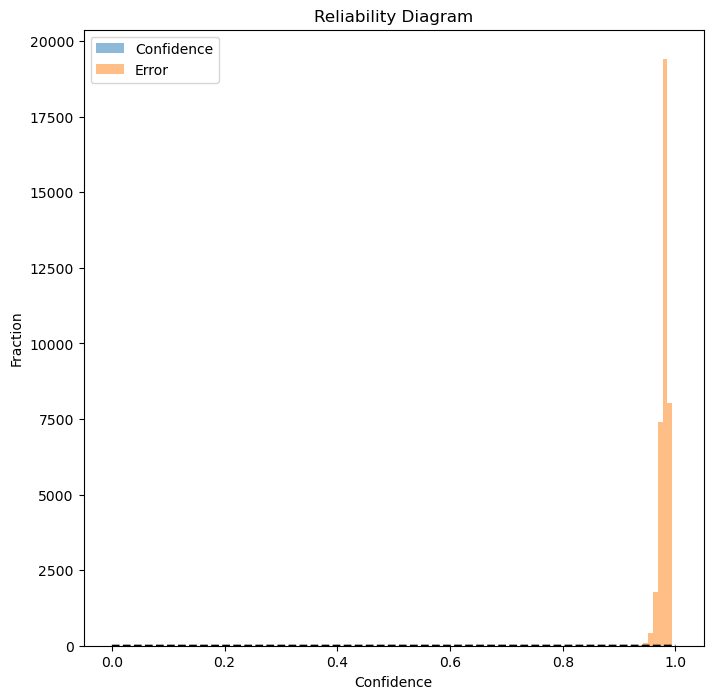

In [19]:
n_bins = 10
one_hot_confidences = np.eye(10)[predictions['labels']] * predictions['confidences'][:, None]

# plot reliability diagram
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.hist(predictions['confidences'], bins=n_bins, weights=np.ones_like(predictions['confidences']) / len(predictions['confidences']), alpha=0.5, label='Confidence')
plt.hist(predictions['confidences'], bins=n_bins, weights=np.abs(predictions['labels'] - predictions['confidences']), alpha=0.5, label='Error')
plt.xlabel('Confidence')
plt.ylabel('Fraction')
plt.title('Reliability Diagram')
plt.legend()
plt.show()


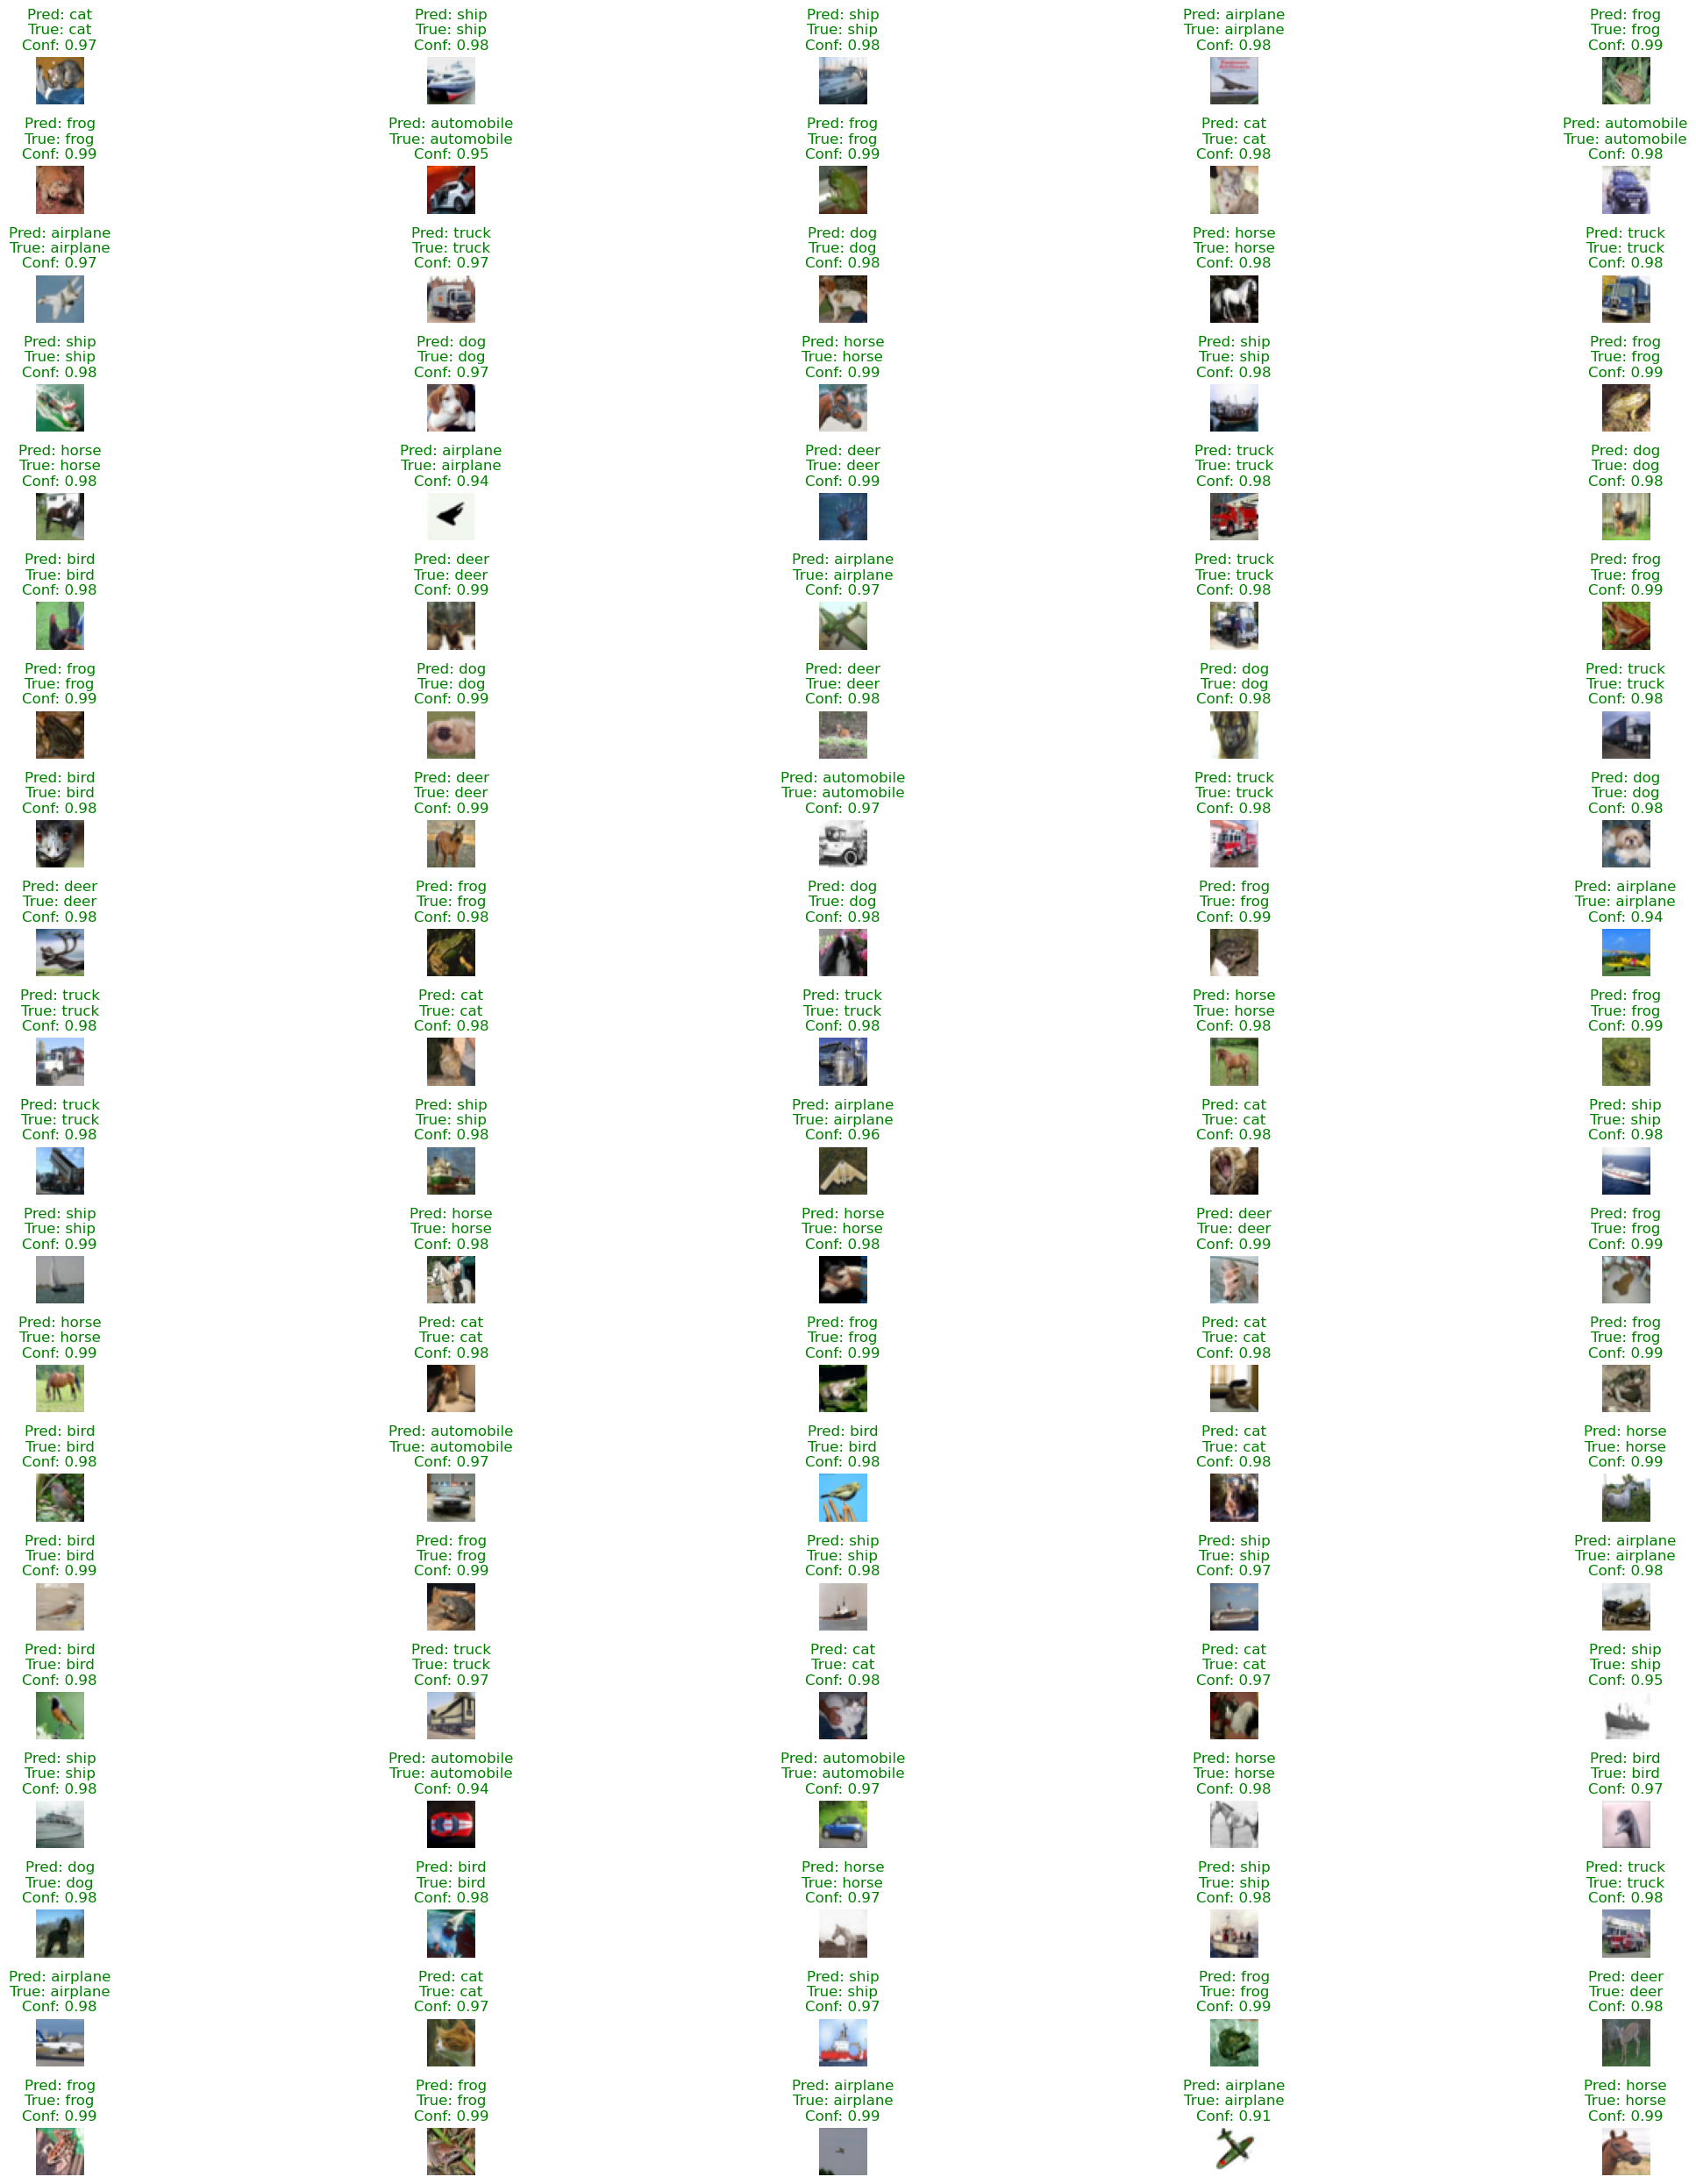

In [18]:
# Then plot predictions
plot_predictions(predictions, num_samples=100)  # Plot first 15 samples